In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import torch

### Load Data 

In [2]:
DATA_DIR = Path.cwd().parent.resolve() / "data/cloud_drivendata/final/public"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [3]:
BANDS = ["B02", "B03", "B04", "B08"]
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        #assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        #assert df["label_path"].path.exists().all()

    return df

print(f"Feature directory : {TRAIN_FEATURES}")
print(f"Label directory : {TRAIN_LABELS}")
train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)

Feature directory : /home/onyxia/work/damaged-building-detector/data/cloud_drivendata/final/public/train_features
Label directory : /home/onyxia/work/damaged-building-detector/data/cloud_drivendata/final/public/train_labels


In [4]:
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.2))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [136]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from transformers import SegformerImageProcessor
from typing import List, Optional

class SemanticSegmentationDataset(Dataset):
    def __init__(
        self,
        x_paths: pd.DataFrame,
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transform = None,
        mask_transform = None,
        processor=None
    ):
        super().__init__()
        self.data = x_paths
        self.label = y_paths
        self.bands = bands
        self.transform = transform
        self.mask_transform = mask_transform
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def load_channel_pil(self, filepath: str):
        return np.array(Image.open(filepath))

    def open_mask(self, filepath: str):
        mask = self.load_channel_pil(filepath) # 0-1 mask (no need to convert into a binary format)
        return mask

    def open_as_array(self, idx: int, invert=False):
        band_arrs = [self.load_channel_pil(self.data.loc[idx][f"{band}_path"]) for band in self.bands]
        x_arr = np.stack(band_arrs, axis=-1)
        # Normalize
        return (x_arr / np.iinfo(x_arr.dtype).max)

    def __getitem__(self, idx: int):
        image = self.open_as_array(idx)
        mask = None 
        
        if self.label is not None:
            mask = self.open_mask(self.label.iloc[idx]['label_path'])

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        encoded_inputs = self.processor(images=image,segmentation_maps=mask, do_reduce_labels=False, return_tensors='pt')

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension
        
        return encoded_inputs
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

In [76]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerImageProcessor

model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
processor = SegformerImageProcessor(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
# output : (batch_size, 150, 128, 128) where 150 : nb_classes, h/4, w/4

In [187]:
import os 
# utils functions
def load_channel_pil(filepath):
        return np.array(Image.open(filepath))

def true_color_img(chip_id, data_dir=TRAIN_FEATURES, load_channel_f=load_channel_pil):
        # Open image files as arrays, optionally including NIR channel

        chip_dir = data_dir / chip_id

        raw_rgb = np.stack([load_channel_f(chip_dir / "B04.tif"),
                            load_channel_f(chip_dir / "B03.tif"),
                            load_channel_f(chip_dir / "B02.tif"),
                           ], axis=-1)
    
        # Normalize pixel values 0-1 values
        return raw_rgb / raw_rgb.max()

def display_random_prediction(model, processor, metadata, chip_id = None, data_dir='TRAIN_FEATURES', alpha=0.5):
    """
    Displays the ground truth and predicted segmentation masks overlaid on the original image.

    Args:
        model (torch.nn.Module): The segmentation model.
        processor (Callable): The processor to preprocess the images for the model.
        metadata (DataFrame): Metadata containing chip IDs and label paths.
        data_dir (str): Directory path containing image data.
        alpha (float): Transparency level for overlaying the mask on the image.
    """
    list_images = os.listdir(path=data_dir)
    if chip_id is None:
        random_chip_id = np.random.choice(list_images)
    else:
        random_chip_id = list_images[chip_id]
    
    # Load image and ground truth from metadata and data directory
    random_chip = metadata[metadata["chip_id"]==random_chip_id].iloc[0]
    image_np = true_color_img(random_chip.chip_id)  # Load the RGB image 
    gt = Image.open(random_chip.label_path)      # Load the ground truth mask
    # Convert the NumPy image array to a PIL image
    image = Image.fromarray(np.uint8(image_np*255)) # as image_np is 0-1 values we need to rescale to 0-255 scale then convert into np.unit8

    # Preprocess image and make predictions
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs["pixel_values"]

    with torch.no_grad():
        outputs = model(inputs) # Cloud_Segformer outputs upsample logits => (1, nb_channel, heigth, width)
        
    # Apply argmax to get the predicted segmentation mask
    pred_seg = outputs.argmax(dim=1)[0].cpu().numpy() # (height, width)
    print("uniques labels :", np.unique(pred_seg))

    # Convert ground truth and prediction to color overlays
    gt_mask = np.array(gt)
    pred_mask = pred_seg

    # Define a colormap for displaying the masks
    colormap = plt.get_cmap("jet")  # Use 'jet' colormap or choose as needed

    # Generate overlays
    gt_overlay = colormap(gt_mask / gt_mask.max())[:, :, :3] * 255  # normalize mask values for display
    pred_overlay = colormap(pred_mask / pred_mask.max())[:, :, :3] * 255

    # Convert overlays to PIL images
    gt_overlay_img = Image.fromarray(gt_overlay.astype(np.uint8)).convert("RGBA")
    pred_overlay_img = Image.fromarray(pred_overlay.astype(np.uint8)).convert("RGBA")

    # Original image as RGBA for transparency blending
    image_rgba = image.convert("RGBA")

    # Blend original image with ground truth and prediction overlays
    gt_display = Image.blend(image_rgba, gt_overlay_img, alpha=alpha)
    pred_display = Image.blend(image_rgba, pred_overlay_img, alpha=alpha)

    # Display the original, ground truth, and prediction images side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(gt_display)
    axs[1].set_title("Ground Truth Overlay")
    axs[1].axis("off")

    axs[2].imshow(pred_display)
    axs[2].set_title("Predicted Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()
    

## Fine Tune Segformer on DrivenData Cloud Segmentation Challenge

In [111]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerImageProcessor

In [137]:
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
processor = SegformerImageProcessor.from_pretrained(model_name) # default image size 512

train_ds = SemanticSegmentationDataset(
            x_paths=train_x,
            bands=["B04", "B03", "B02"],
            y_paths=train_y,
            processor=processor,
        )
valid_ds = SemanticSegmentationDataset(
            x_paths=val_x,
            bands=["B04", "B03", "B02"],
            y_paths=val_y,
            processor=processor
        )

train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [168]:
print("Number of training examples:", len(train_ds))
print("Number of validation examples:", len(valid_ds))

Number of training examples: 9398
Number of validation examples: 2350


In [169]:
inputs = next(iter(train_dl))

In [180]:
class Cloud_Segformer(nn.Module):
    def __init__(self):
        super(Cloud_Segformer, self).__init__()
        
        self.segformer = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b1-finetuned-ade-512-512')
        self.segformer.decode_head.classifier = nn.Conv2d(256,2,kernel_size=1) # replace classifier head (classifier): Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, image):
        pred_mask_logits = self.segformer(image).logits
        pred_mask = nn.functional.interpolate(pred_mask_logits, image.shape[-2:], mode="bilinear", align_corners=True)
        pred_mask = pred_mask.squeeze(1)
        return pred_mask

In [181]:
model = Cloud_Segformer()

uniques labels : [0]


/tmp/ipykernel_2126/2676323427.py:63: RuntimeWarning: invalid value encountered in divide
  pred_overlay = colormap(pred_mask / pred_mask.max())[:, :, :3] * 255


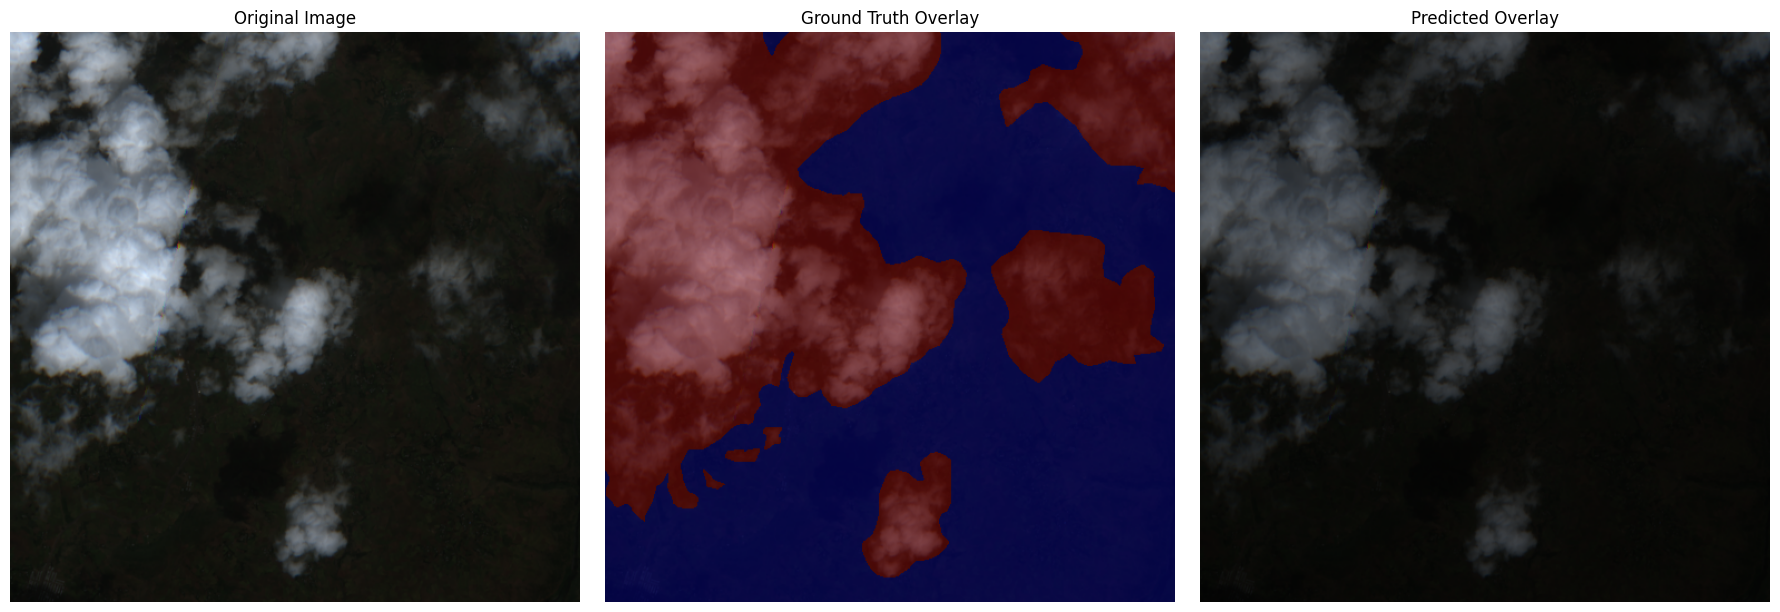

In [188]:
display_random_prediction(model, processor, metadata=train_meta, data_dir=TRAIN_FEATURES, alpha=0.5, chip_id=30)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)